# Homework 2: merging dataframes, inferential statistics

In [57]:
import pandas as pd
from matplotlib import pyplot as plt
from pathlib import Path
from scipy.stats import pearsonr
import numpy as np

### PROBLEM 1:

In our lab ```Movies and Statistics```, we discovered that women speak on average 851 words per film in this dataset; men 933.

How often would a difference of means like that occur by chance? If the null hypothesis is that the number of words for women and for men comes from the same distribution, use a t test to evaluate the probability of the observed data given the null hypothesis.

In [3]:
charpath = Path('../data/pudding/pudding_characters.csv')
chars = pd.read_csv(charpath, encoding = 'utf-8')
chars.head()

,script_id,imdb_character_name,words,gender,age
0,280,betty,311,f,35.0
1,280,carolyn johnson,873,f,NaN
2,280,eleanor,138,f,NaN
3,280,francesca johns,2251,f,46.0
4,280,madge,190,f,46.0


In [4]:
mcharwords = chars.loc[chars['gender'] == 'm', 'words']
fcharwords = chars.loc[chars['gender'] == 'f', 'words']

#### There are several valid ways to approach this

Here's the simplest one: don't exclude any characters.

In [17]:
np.mean(mcharwords) # this step is optional

932.6529878502356

In [18]:
np.mean(fcharwords)  # also optional

850.4785125162784

In [10]:
from scipy.stats import ttest_ind

In [11]:
ttest_ind(mcharwords, fcharwords)  # this is key

Ttest_indResult(statistic=4.084984432671419, pvalue=4.422877543621665e-05)

It could be equally valid to perform a Welch's t test. To do use, you use the same function and simply instruct it not to assume that the two vectors being compared have the same variance.

In [16]:
ttest_ind(mcharwords, fcharwords, equal_var = False)

Ttest_indResult(statistic=4.420597436503074, pvalue=9.908485935594459e-06)

#### Another possibility: in class we excluded characters older than 1000.

In [19]:
humans = chars[chars['age'] <= 1000]

In [20]:
ttest_ind(humans.loc[humans['gender'] == 'm', 'words'], humans.loc[humans['gender'] == 'f', 'words'])

Ttest_indResult(statistic=4.0144930201137266, pvalue=5.981186155583732e-05)

I didn't specifically ask them to interpret this result, so simply generating the pvalue is enough. They don't have to write a sentence of interpretation.

### PROBLEM 2:

In the lab, we grouped characters by *movie title*, calculated the fraction of dialogue spoken by women in each movie, and compared that to movies' release year.

We found a significant relationship.

But what if you grouped characters by *release year* and calculated the fraction of dialogue spoken by women in each *year*?

Try generating a data frame with that information. Then measure the Pearson correlation between the year column and the fraction-of-dialogue-by-women column. Is the p value still less than .05? 

How do you explain the discrepancy between these two experiments? (Write a sentence or two explaining the difference you've observed.)

#### Merging frames

To answer this question it will be necessary to merge the frame of characters with a frame of movies.

First we read it.

In [22]:
moviepath = Path('../data/pudding/pudding_movies.csv')
movies = pd.read_csv(moviepath, encoding = 'utf-8')
movies.head()

,script_id,imdb_id,title,year,gross,lines_data
0,1534,tt1022603,(500) Days of Summer,2009,37.0,7435445256774780000000000000000000000000000000...
1,1512,tt0147800,10 Things I Hate About You,1999,65.0,1777752320274530000000000000000000000000000000...
2,1514,tt0417385,12 and Holding,2005,NaN,5461357777754220000000000000000000000000000000...
3,1517,tt2024544,12 Years a Slave,2013,60.0,4567334777777780000000000000000000000000000000...
4,1520,tt1542344,127 Hours,2010,20.0,453513352345766000000000000000


Then we merge the two frames on ```script_id.```

In [47]:
merged = pd.merge(chars, movies, on = 'script_id')

Now we need to calculate the fraction of words spoken by women in each year. There are a variety of ways to do this.

First, the way I showed in class. We can split the merged frame by character gender, group it by year, and calculate the total number of words spoken by characters of that gender in each year.

In [27]:
malewordsbyyear = merged.loc[merged['gender'] == 'm', : ].groupby('year', as_index = False).sum()

In [40]:
femalewordsbyyear = merged.loc[merged['gender'] == 'f', : ].groupby('year', as_index = False).sum()

Then we can merge the male and female dataframes while assigning them different suffixes.

In [41]:
wordsbyyear = femalewordsbyyear.merge(malewordsbyyear, on = 'year', how = 'outer', suffixes = ['_women', '_men'])

In [42]:
wordsbyyear.head()

,year,script_id_women,words_women,age_women,gross_women,script_id_men,words_men,age_men,gross_men
0,1929,12093,1412,99.0,0.0,12093,7160,123.0,0.0
1,1931,9607,2337,43.0,298.0,40600,9264,406.0,1192.0
2,1932,27732,17933,281.0,0.0,105172,49601,1849.0,0.0
3,1933,18401,5172,135.0,0.0,84709,15953,675.0,0.0
4,1934,35901,7723,190.0,0.0,82128,16923,595.0,0.0


Discard unneeded columns.

In [43]:
wordsbyyear = wordsbyyear.loc[ : , ['year', 'words_men', 'words_women']]

Now we can create a column that reports the fraction of words spoken by women, simply by calculating a relationship between the two columns ```words_women``` and ```words_men```. Note that Pandas Series can be added and divided en masse, like numpy arrays.

In [44]:
wordsbyyear = wordsbyyear.assign(frac_women = wordsbyyear['words_women'] / 
                                     (wordsbyyear['words_women'] + wordsbyyear['words_men']))

This is the result.

In [45]:
wordsbyyear.head()

,year,words_men,words_women,frac_women
0,1929,7160,1412,0.164722
1,1931,9264,2337,0.201448
2,1932,49601,17933,0.265540
3,1933,15953,5172,0.244828
4,1934,16923,7723,0.313357


<AxesSubplot:xlabel='year', ylabel='frac_women'>

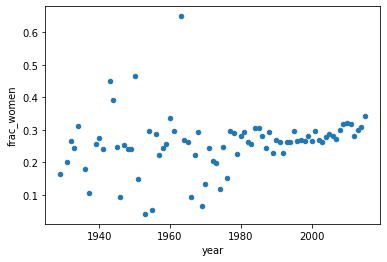

In [46]:
wordsbyyear.plot(kind = 'scatter', x = 'year', y = 'frac_women')

**An alternate way to do this** is to define a function and use the ```.apply()``` method, which applies a function across the elements of a group_by object.

In [55]:
def get_fraction_words_by_women(df):
    
    ''' Given a data frame for a specific year, this calculates the total number of words spoken
    by male characters in that year, and the number for women.
    
    Then it returns the fraction spoken by women. Returning this value as a Series allows us
    to set the column name. But we could just return the number.
    '''
    
    summalewords = np.sum(df.loc[df['gender'] == 'm', 'words'])
    sumfemalewords = np.sum(df.loc[df['gender'] == 'f', 'words'])
    year = df.at[df.index[0], 'year']
    return pd.Series({'frac_women': sumfemalewords / (summalewords + sumfemalewords)})

# We group by year, then use the .apply() method to map our function across the dataframes
# for different years.

grouped = merged.groupby('year', as_index = False)
altwordsbyyear = grouped.apply(get_fraction_words_by_women)
altwordsbyyear.head()

,year,frac_women
0,1929,0.164722
1,1931,0.201448
2,1932,0.265540
3,1933,0.244828
4,1934,0.313357


This produces the same result.

<AxesSubplot:xlabel='year', ylabel='frac_women'>

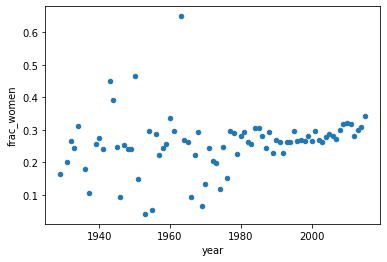

In [56]:
altwordsbyyear.plot(kind = 'scatter', x = 'year', y = 'frac_women')

In [58]:
pearsonr(wordsbyyear['year'], wordsbyyear['frac_women'])

(0.2073722977986568, 0.06322721137239326)

So *r* is reported as .207, and the p value as .063.

This result appears not to be significant at *p* < .05, even though when we grouped characters by movie (by 'title'), we got a distinctly significant correlation between the same two variables: release year and ```frac_women.``` *R* in that case was 0.090, and p was .00006.

Of course, in that case we had many more data points. There are approximately 2000 titles, and only 81 years in this dataset. When there are lots of data points, it becomes less likely that a given pattern would appear under the null hypothesis. So one lesson we might draw from this comparison is that *p* values are not a very stable way to assess the strength of a pattern. They're very sensitive to data size, which means that a result can gain or lose statistical significance depending on the way data is grouped and aggregated.